# Laboratorium 9 - Algorytm aktywnych konturów - Snakes


W ramach laboratorium zostanie zaimplementowany jeden z półautomatycznych algorytmów segmentacji - algorytm aktywnych konturów w wersji snakes. W przeszłości służył on do m.in. poprawy manualnych konturów wyznaczanych przez lekarzy w trakcie planowania terapii nowotworowych. Obecnie nie jest już stosowany, został wyparty przez algorytmy bazujące na uczeniu głębokim, jednak jego implementacja dalej stanowi użyteczne ćwiczenie wprowadzające do problematyki przetwarzania i analizy obrazów.

Zacznijmy od wygenerowania kilku syntentycznych obrazów:

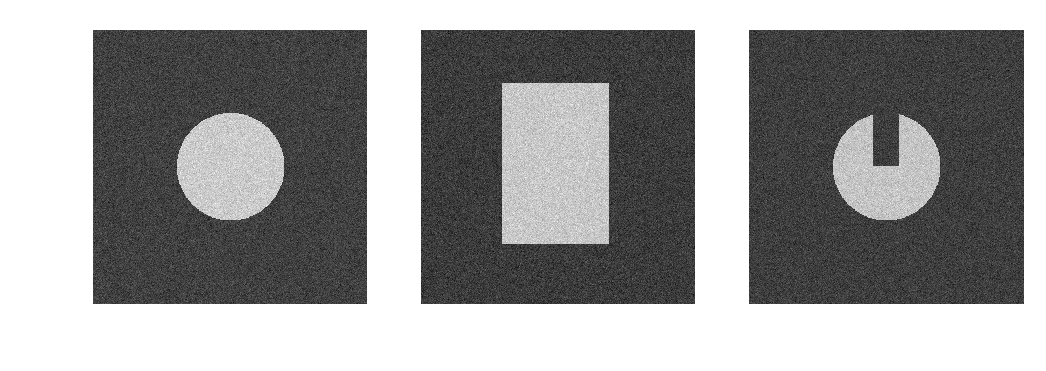

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as nd
from scipy import interpolate
from scipy import linalg
%matplotlib inline

def generate_circle(y_size, x_size, x_origin, y_origin, radius):
    image = np.zeros((y_size, x_size))
    x_grid, y_grid = np.meshgrid(np.arange(x_size), np.arange(y_size))
    indices = np.square((x_grid - x_origin)) + np.square((y_grid-y_origin)) < radius*radius
    image[indices] = 1
    return image

y_size, x_size = 512, 512
radius = 100
x_origin, y_origin = 256, 256
image_circle = generate_circle(y_size, x_size, x_origin, y_origin, radius)
image_rectangle = np.zeros((y_size, x_size))
image_rectangle[100:400, 150:350] = 1 
image_ushape = image_circle.copy()
image_ushape[0:256, 230:280] = 0

image_circle = image_circle + np.random.randn(y_size, x_size)*0.1
image_rectangle = image_rectangle + np.random.randn(y_size, x_size)*0.1
image_ushape = image_ushape + np.random.randn(y_size, x_size)*0.1

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image_circle, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(image_rectangle, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(image_ushape, cmap='gray')
plt.axis('off')
plt.show()

W pierwszym kroku stwórzmy funkcję, która pozwoli na manualy wybór początkowego konturu (1p).

Funkcja powinna tworzyć okno z obrazem, na którym jest możliwe klikanie punktów. Kliknięcie lewym przyciskiem myszy powinno dodawać nowy punkt, prawym usuwać ostatnio dodany, a kiknięcie dowolnego innego przycisku myszy powinno kończyć rysowanie i zwracać kontur. Kontur powinien być konturem zamkniętym, tj. punkt pierwszy i ostatni powinny być identyczne. Aktualny stan konturu powinien być na bieżąco wyświetlany.

Wskazówka: użyj zaproponowanej struktury klasy (jej instancja powinna być tworzona w funkcji click_points) i button_press_event w bibliotece matplotlib.

In [2]:
%matplotlib tk

# Aby wyświetlić okno interaktywnie poza notatnikiem wyżej został zmieniony tryb wyświetlania
def click_points(image):
    """
    image - obraz wejściowy (YxX)
    """
    # TO DO
    xs, ys = None, None
    return xs, ys

class ContourCreator(object):
    # TO DO
    def __init__(self, plot):
        pass
    def __call__(self, event):
        pass
    def redraw(self):
        pass

Przykładowe użycie:


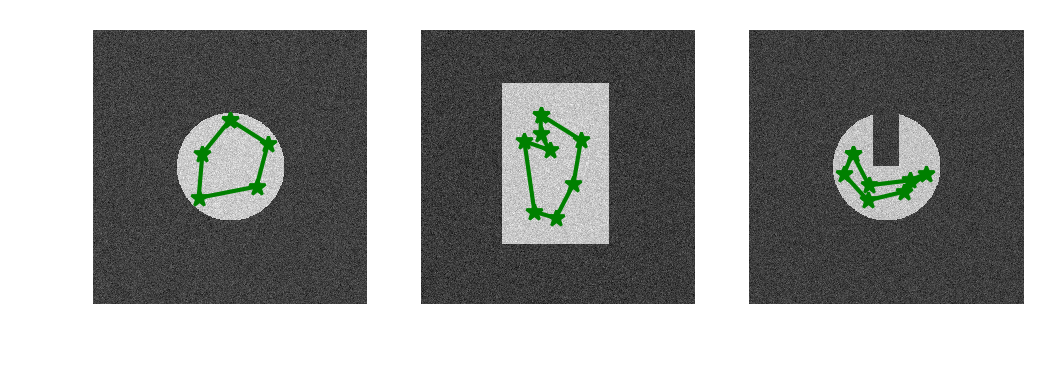

In [3]:
%matplotlib tk

xs_c, ys_c = click_points(image_circle)
xs_r, ys_r = click_points(image_rectangle)
xs_u, ys_u = click_points(image_ushape)

%matplotlib inline

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image_circle, cmap='gray')
plt.axis('off')
plt.plot(xs_c, ys_c, "g*-")
plt.subplot(1, 3, 2)
plt.imshow(image_rectangle, cmap='gray')
plt.axis('off')
plt.plot(xs_r, ys_r, "g*-")
plt.subplot(1, 3, 3)
plt.imshow(image_ushape, cmap='gray')
plt.axis('off')
plt.plot(xs_u, ys_u, "g*-")
plt.show()

Następnie dokonaj zagęszczenia konturu (0.5p). W tym celu zaimplementuj funkcję reinterpolate_contours, która jako argumenty przyjmuje kontur wejsciowy (wyklikany), minimalną oraz maksymalną odległość między punktami konturu. Istnieje mnóstwo możliwości implementacji powyższej funkcji i spełnienia jej założeń (odległość między punktami nie może być mniejsza niż dmin i większa niż dmax)

In [4]:
def reinterpolate_contours(xs, ys, dmin, dmax):
    # TO DO
    return xs, ys

Przykładowy wynik działania funkcji:

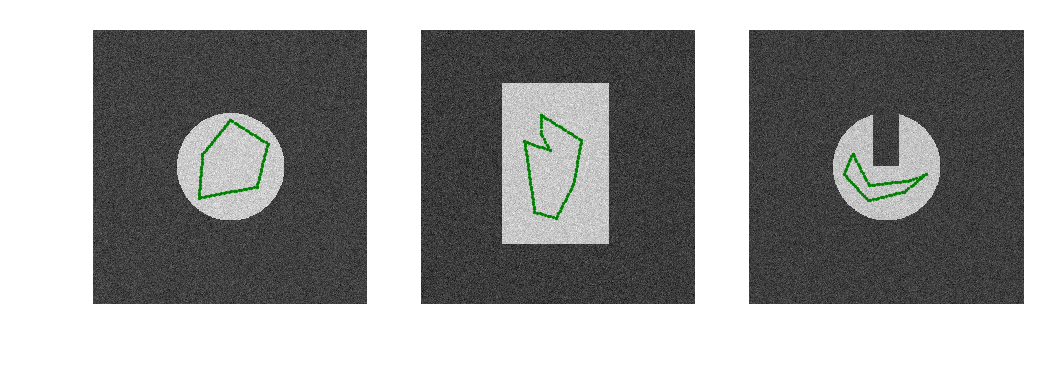

In [5]:
xs_cr, ys_cr = reinterpolate_contours(xs_c, ys_c, 3, 6)
xs_rr, ys_rr = reinterpolate_contours(xs_r, ys_r, 3, 6)
xs_ur, ys_ur = reinterpolate_contours(xs_u, ys_u, 3, 6)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image_circle, cmap='gray')
plt.axis('off')
plt.plot(xs_cr, ys_cr, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 3, 2)
plt.imshow(image_rectangle, cmap='gray')
plt.axis('off')
plt.plot(xs_rr, ys_rr, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 3, 3)
plt.imshow(image_ushape, cmap='gray')
plt.axis('off')
plt.plot(xs_ur, ys_ur, "g*-", markersize=0.5, linewidth=0.1)
plt.show()


W kolejnym kroku przechodzimy do implementacji właściwej części algorytmu (1.5p).

Należy zaimplementować funkcję active contour, która będzie wywoływać funkcje generate_coefficient_matrix, calculate_gradient_at_contour_points oraz update_contour.

1) Funkcja generate_coefficient_matrix generuje macierz współczynników konturu na podstawie parametrów wejściowych alpha i beta dla N punktów. Zakładamy podstawową wersje algorytmu, gdzie alpha i beta są stałe i równe dla każdego punktu.

2) Funkcja calculate_gradient_at_contour_points powinna zwracać wartość gradientu w punktach konturu (gradient jako parametr wejściowy). Uwaga: punkty konturu mogą (a nawet na pewno będą) wartościami niecałkowitymi. Wartości gradientu w tych punktach należy liczyć wykorzystująć interpolacje, nie zaokrąglanie do najbliższej całkowitej wartości.

3) Funkcja update_contour przyjmuje aktualne wartości konturu, parametry algorytmu (gamma, kappa), macierz współczynników konturu, gradient obrazu (x, y) oraz to czy korzystamy z siły balonowej (oraz opcjonalnie parametr siły balonowej - theta).

4) Funkcja active_contour implementuje algorytm aktywnych konturów (obraz wejściowy, wyklikany kontur oraz poszczególne parametry algorytmu). Parametr iterations określa liczbę iteracji. Parametr reinterp_iterations oznacza co ile iteracji algorytmu należy ponownie reinterpolować kontur (będzie się kurczył lub rozszerzał w miare postępu algorytmu). Parametr draw określa czy wynik ma być na bieżąco rysowany w osobnym oknie. Funkcja zwraca finalne położenie konturu.


In [6]:
def generate_coefficient_matrix(N, alpha, beta):
    # TO DO
    A = np.eye(N)
    return A

In [7]:
def calculate_gradient_at_contour_points(xs, ys, x_gradient, y_gradient):
    # TO DO
    xs_gradient = xs
    ys_gradient = ys
    return xs_gradient, ys_gradient


In [8]:
def update_contour(xs, ys, gamma, kappa, inverted_propagation_matrix, xs_gradient, ys_gradient, balloon=True, theta=1):
    # TO DO
    return xs, ys

In [9]:
def active_contour(image, xs, ys, alpha, beta, gamma, kappa, dmin=2, dmax=5, iterations=100, reinterp_iterations=5, draw=False, balloon=True, theta=1):
    # TO DO
    return xs, ys

Przykład generowania macierzy współczynników:

In [10]:
N = 5
alpha = 0.1
beta = 0.1
print("Propagation matrix: ")
print(generate_coefficient_matrix(N, alpha, beta))

Propagation matrix: 
[[ 0.8 -0.5  0.1  0.1 -0.5]
 [-0.5  0.8 -0.5  0.1  0.1]
 [ 0.1 -0.5  0.8 -0.5  0.1]
 [ 0.1  0.1 -0.5  0.8 -0.5]
 [-0.5  0.1  0.1 -0.5  0.8]]


Przykład obliczania gradientu w punkach konturu:

In [11]:
np.random.seed(123)
y_gradient = np.random.randn(5, 5)
x_gradient = np.random.randn(5, 5)
xs = [0.5, 1.5, 2.5]
ys = [0.5, 1.2, 1.7]
print("Gradient at contour location: ")
g_xs, g_ys = calculate_gradient_at_contour_points(xs, ys, x_gradient, y_gradient)
print("X: ", g_xs)
print("Y: ", g_ys)

Gradient at contour location: 
X:  [-0.6962137  -1.75894202 -0.43767132]
Y:  [-0.21588197 -1.00256868  0.42392421]


Przykład działania funkcji active_contour:

In [12]:
%matplotlib tk

xs_c, ys_c = click_points(image_circle)
xs_r, ys_r = click_points(image_rectangle)
xs_u, ys_u = click_points(image_ushape)

%matplotlib inline

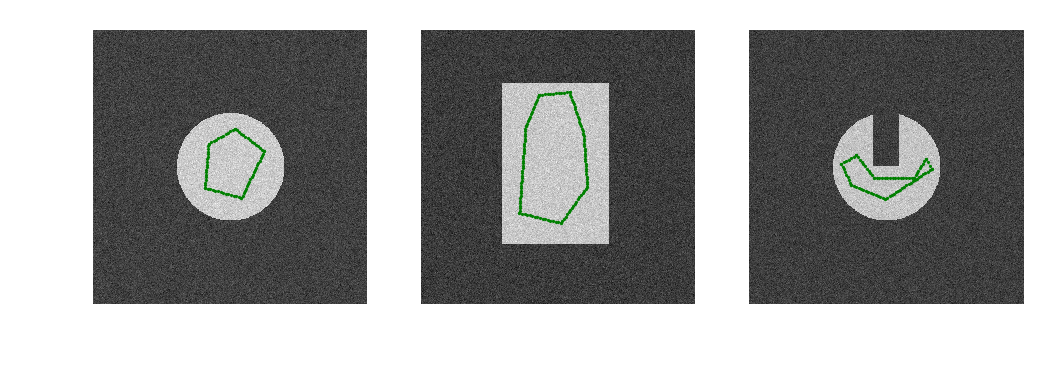

In [13]:
xs_cr, ys_cr = reinterpolate_contours(xs_c, ys_c, 3, 6)
xs_rr, ys_rr = reinterpolate_contours(xs_r, ys_r, 3, 6)
xs_ur, ys_ur = reinterpolate_contours(xs_u, ys_u, 3, 6)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image_circle, cmap='gray')
plt.axis('off')
plt.plot(xs_cr, ys_cr, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 3, 2)
plt.imshow(image_rectangle, cmap='gray')
plt.axis('off')
plt.plot(xs_rr, ys_rr, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 3, 3)
plt.imshow(image_ushape, cmap='gray')
plt.axis('off')
plt.plot(xs_ur, ys_ur, "g*-", markersize=0.5, linewidth=0.1)
plt.show()

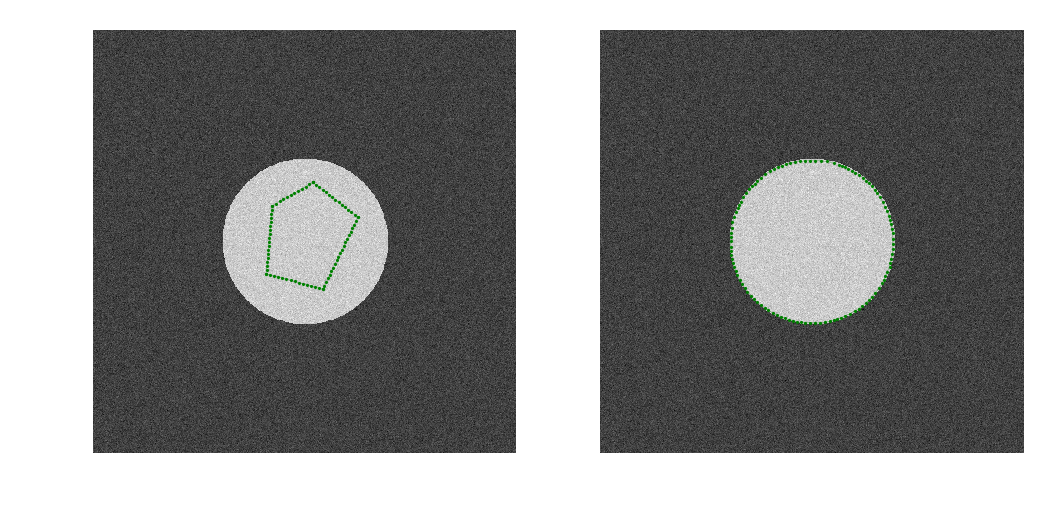

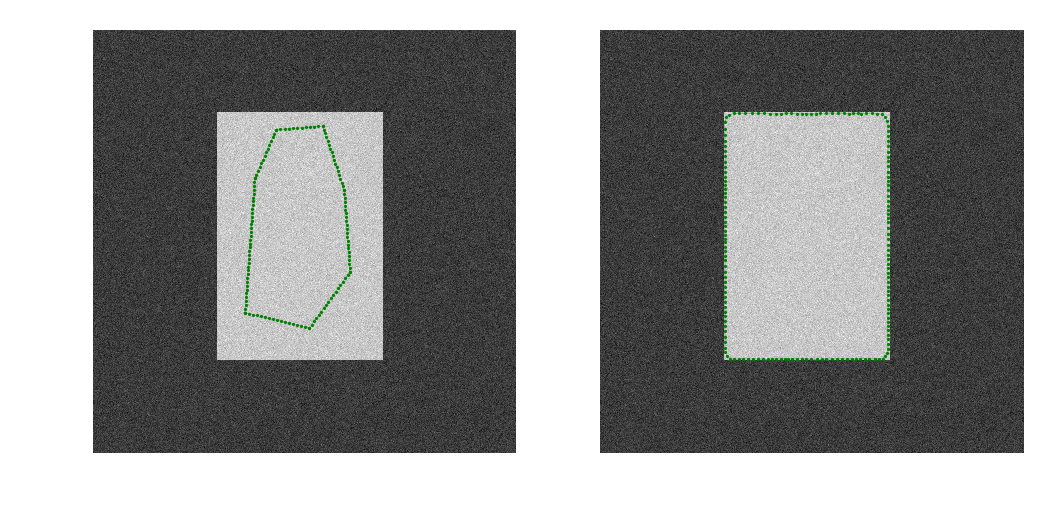

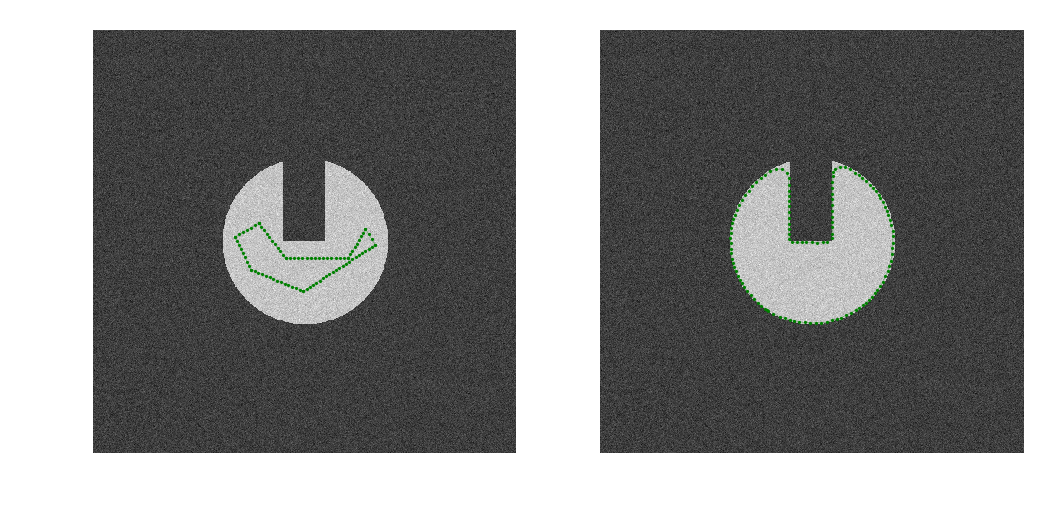

In [14]:
dmin = 3
dmax = 5
alpha = 0.02
beta = 0.05
gamma = 0.7
kappa = 70000
iterations = 1000
reinterp_iters = 5
draw = True
balloon = True
theta = 35

n_xs_cr, n_ys_cr = active_contour(image_circle, xs_cr, ys_cr, alpha, beta, gamma, kappa,
                            dmin=dmin, dmax=dmax, iterations=iterations,
                            reinterp_iterations=reinterp_iters, draw=draw,
                            balloon=balloon, theta=theta)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image_circle, cmap='gray')
plt.axis('off')
plt.plot(xs_cr, ys_cr, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 2, 2)
plt.imshow(image_circle, cmap='gray')
plt.axis('off')
plt.plot(n_xs_cr, n_ys_cr, "g*-", markersize=0.5, linewidth=0.1)
plt.show()    

n_xs_rr, n_ys_rr = active_contour(image_rectangle, xs_rr, ys_rr, alpha, beta, gamma, kappa,
                            dmin=dmin, dmax=dmax, iterations=iterations,
                            reinterp_iterations=reinterp_iters, draw=draw,
                            balloon=balloon, theta=theta)
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image_rectangle, cmap='gray')
plt.axis('off')
plt.plot(xs_rr, ys_rr, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 2, 2)
plt.imshow(image_rectangle, cmap='gray')
plt.axis('off')
plt.plot(n_xs_rr, n_ys_rr, "g*-", markersize=0.5, linewidth=0.1)
plt.show() 

n_xs_ur, n_ys_ur = active_contour(image_ushape, xs_ur, ys_ur, alpha, beta, gamma, kappa,
                            dmin=dmin, dmax=dmax, iterations=iterations,
                            reinterp_iterations=reinterp_iters, draw=draw,
                            balloon=balloon, theta=theta)
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image_ushape, cmap='gray')
plt.axis('off')
plt.plot(xs_ur, ys_ur, "g*-", markersize=0.5, linewidth=0.1)
plt.subplot(1, 2, 2)
plt.imshow(image_ushape, cmap='gray')
plt.axis('off')
plt.plot(n_xs_ur, n_ys_ur, "g*-", markersize=0.5, linewidth=0.1)
plt.show()  
